<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/Ct_lung_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from zipfile import ZipFile
file_id = 'https://drive.google.com/open?id=1tnhNJB85sRAwCfmZqjSkq_YU9Cf86LIT' #tr_im.nii.gz
downloaded = drive.CreateFile({'id': file_id.split("=")[-1]})
downloaded.GetContentFile('tr_im.nii.gz')
 
file_id = 'https://drive.google.com/open?id=1AWM6y2b0gYBFHKWZS75Z2V4n77LxzCis' #tr_lungmsk_updated.nii.gz
downloaded = drive.CreateFile({'id': file_id.split("=")[-1]})
downloaded.GetContentFile('tr_im_msk.nii.gz')
 
 
file_id = 'https://drive.google.com/open?id=1-Xni5SdlW3G3S7S-DdCy_wdun3PTRgjj' #rp_im.zip
downloaded = drive.CreateFile({'id': file_id.split("=")[-1]})
downloaded.GetContentFile('rp_im.zip')
with ZipFile('rp_im.zip', 'r') as tt:
  tt.extractall("")
 
 
file_id = 'https://drive.google.com/open?id=1l6dEuNFbn2iD6_oq8Ahf0H0XlyoVz1k1' #rp_lung_msk.zip
downloaded = drive.CreateFile({'id': file_id.split("=")[-1]})
downloaded.GetContentFile('rp_lung_msk.zip')
with ZipFile('rp_lung_msk.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id3='https://drive.google.com/open?id=1IN_v5VmqNTOx9E5XW9FEWN4x24YKgtON' 
downloaded = drive.CreateFile({'id': file_id3.split("=")[-1]})
downloaded.GetContentFile('segment.h5')

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers,activations
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
size = 320
min_area = 5000
imgs = []
masks = []

rgb_image = nib.load("tr_im.nii.gz")
img_full = np.array(rgb_image.get_fdata())
mask_lung = nib.load("tr_im_msk.nii.gz")
mask_lung_full = np.array(mask_lung.get_fdata())
for i in range(img_full.shape[2]):
    im = cv2.resize(img_full[:,:,i],(size,size))
    mk = cv2.resize(mask_lung_full[:,:,i],(size,size))
    _,mk = cv2.threshold(mk,0.5,1,cv2.THRESH_BINARY)
    if np.sum(mk) < min_area:
        continue
        
    imgs.append(im)
    masks.append(mk)

for i in range(1,10):
  rgb_image2 = nib.load(f'rp_im/{i}.nii.gz')
  img_full2 = np.array(rgb_image2.get_fdata())
  rgb_mask = nib.load(f'rp_lung_msk/{i}.nii.gz')
  mask_full = np.array(rgb_mask.get_fdata())
  for j in range(img_full2.shape[2]):
    im = cv2.resize(img_full2[:,:,j],(size,size))
    mk = cv2.resize(mask_full[:,:,j],(size,size))
    _,mk = cv2.threshold(mk,0.5,1,cv2.THRESH_BINARY)
    if np.sum(mk) < min_area:
        continue
    imgs.append(im)
    masks.append(mk)


In [ ]:
imgs = np.asarray(imgs)
masks = np.asarray(masks)
print(imgs.shape,masks.shape)
imgs = np.expand_dims(imgs,3)
masks = np.expand_dims(masks,3)
imgs_train = imgs[:600]
imgs_dev = imgs[600:]
masks_train = masks[:600]
masks_dev = masks[600:]
print(imgs_train.shape,masks_train.shape)
print(imgs_dev.shape,masks_dev.shape)


(653, 320, 320) (653, 320, 320)
(600, 320, 320, 1) (600, 320, 320, 1)
(53, 320, 320, 1) (53, 320, 320, 1)


In [ ]:
imgs.max(), imgs.min()

(592.797167693268, -1606.521739130435)

In [ ]:
model = unet(input_shape,2)
model.load_weights("/content/segment.h5")
mask_pre = model.predict(imgs_dev)

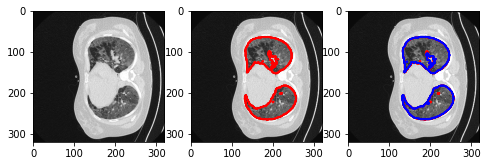

In [ ]:
iii = 11
m = mask_pre[iii][:,:,0]
m1 = masks_dev[iii][:,:,0]
plt.figure(figsize = (8,8))
plt.subplot(131)
plt.imshow(imgs_dev[iii][:,:,0],cmap= "gray")
plt.subplot(132)
plt.imshow(imgs_dev[iii][:,:,0],cmap= "gray")
plt.contour(m1, colors = 'red')
plt.subplot(133)
plt.imshow(imgs_dev[iii][:,:,0],cmap= "gray")
plt.contour(m1, colors = 'red')
plt.contour(m,colors = "blue")


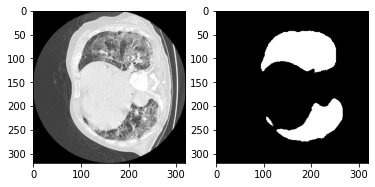

16172.0


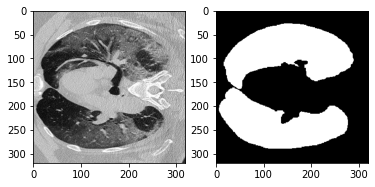

41337.0


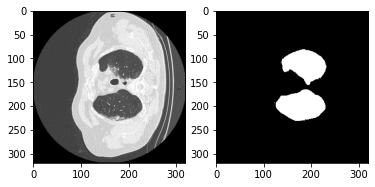

9275.0


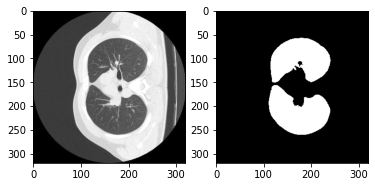

16947.0


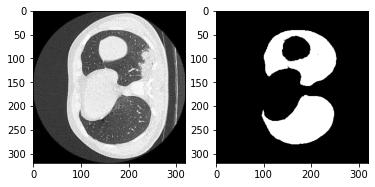

19450.0


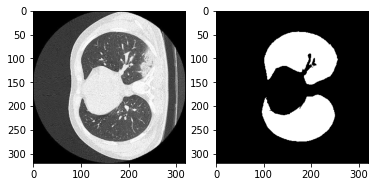

20602.0


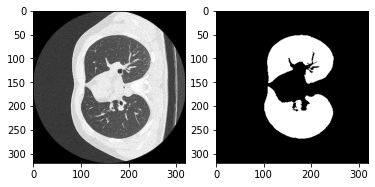

19140.0


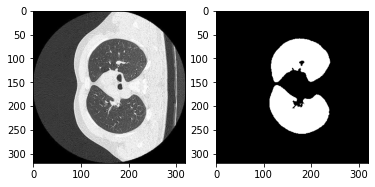

15996.0


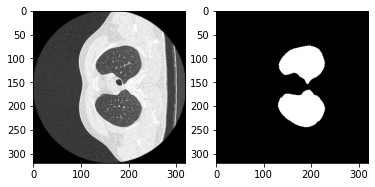

10552.0


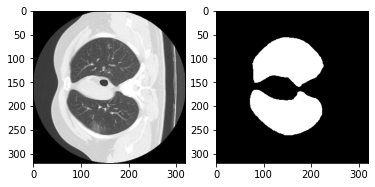

20384.0


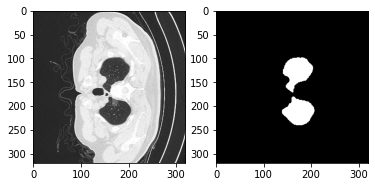

5489.0


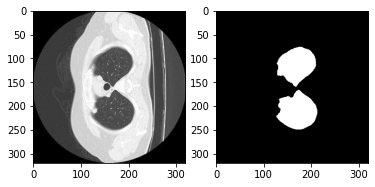

9511.0


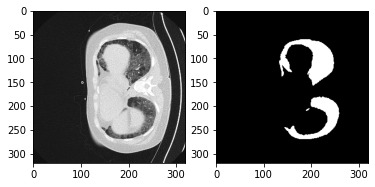

8101.0


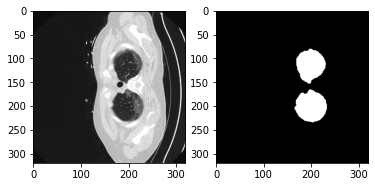

6554.0


In [ ]:
def visualize(X,Y, num_visual):
  for idx,i in enumerate(X):
    if idx%num_visual == 0:
        img = i
        plt.figure(idx//num_visual)
        plt.subplot(121)
        plt.imshow(img[:,:,0],cmap="gray")
        
        
        plt.subplot(122)
        plt.imshow(Y[idx][:,:,0],cmap="gray")
        plt.show() 
        print(np.sum(Y[idx]))

visualize(imgs,masks,50)

In [ ]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)
def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate

def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)


    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)


    att_x = multiply([x, rate])

    return att_x

In [ ]:
def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None,):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = data, outputs = conv10)

    
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.1,
    rotation_range = 180,
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.1,
    rotation_range = 180,
)
seed = 1234
batch = 2

x_gen = generator_x.flow(imgs_train, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks_train, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

NameError: ignored

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
size = 320
input_shape = (size, size, 1)
model = unet(input_shape,2)
model.load_weights("/content/segment.h5")
with open("unet_segment_lung.json","w") as f:
    g = model.to_json()
    f.write(g)
model.compile(optimizer = SGD(lr = 0.01,momentum=0.9), loss = dice_coef_loss, metrics = ['accuracy',dice_coef])
checkpoint = ModelCheckpoint('weights_save/{epoch:02d}_{val_dice_coef:.2f}.h5',
                             monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
#lr_decay = lr_scheduler()
callback_list = [checkpoint]
model.fit_generator(train_generator, steps_per_epoch = imgs.shape[0]//batch, 
                              epochs = 60, validation_data = (imgs_dev, masks_dev), callbacks =callback_list)

NameError: ignored

In [ ]:
model.load_weights("/content/weights_save/10_0.98.h5")
y_pre = model.predict(imgs_dev)

In [ ]:

plt.imshow(imgs_dev[1][:,:,0],cmap="gray")
plt.show()
plt.imshow(y_pre[1][:,:,0])
plt.show()